In [1]:
import os

import numpy as np
from matplotlib import pyplot as plt
import cv2

import test
import mask
import roi
import utils

import time

/home/izabel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
[2018-11-19 20:36:10 @__init__.py:79] Set root logger. Unset logger with neuralgym.unset_logger().
[2018-11-19 20:36:10 @__init__.py:80] Saving logging to file: neuralgym_logs/20181119203610233041.


In [2]:
# Imagem de entrada (sem extensão)
img_name = 'img_52'

# Extensão da imagem de entrada
img_extension = '.jpg'

In [3]:
# Diretórios da imagem original, arquivos temp. e restauração final
images_dir = './images/'
interm_dir = './interm_files/'
inpaint_dir = './inpaints/'

checkpoint_dir = './model_logs/release_celeba_256/'

# Verifica se existem os diretórios e cria os que não existem
if not os.path.exists(interm_dir):
    os.mkdir(interm_dir)
if not os.path.exists(inpaint_dir):
    os.mkdir(inpaint_dir)

Validando a imagem de entrada...OK


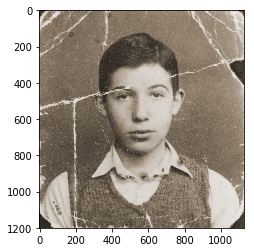

In [4]:
print('Validando a imagem de entrada...', end = '')
image = utils.validate_input_image(images_dir + img_name + img_extension, img_extension)
print('OK')

plt.figure()
plt.imshow(image)

Identificando o rosto na imagem... OK


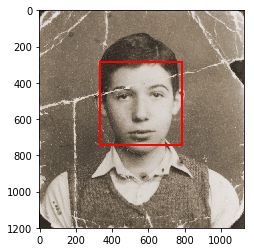

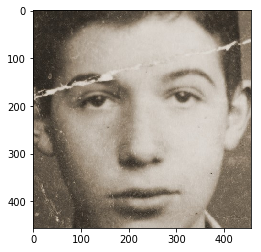

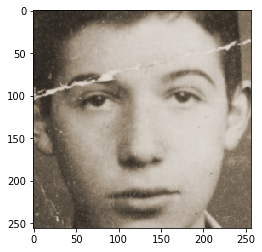

In [5]:
print('Identificando o rosto na imagem...', end = ' ')
x, y, w, h = roi.identify_face(image)
print('OK')

# Exibe o rosto identificado
image_copy = np.copy(image)
cv2.rectangle(image_copy, (x,y), (x+w,y+h), (255,0,0), 10)
plt.figure()
plt.imshow(image_copy)

# Corta a região do rosto
image_cropped = image[y:y+h, x:x+w]

# Salva a região do rosto em disco
cv2.imwrite(interm_dir + img_name + '_cropped' + img_extension, cv2.cvtColor(image_cropped, cv2.COLOR_BGR2RGB))

# Exibe o rosto salvo em disco
plt.figure()
plt.imshow(image_cropped)

# Redimensiona o rosto
face = utils.resize_face(w, h, image_cropped)

# Salva o rosto redimensionado em disco
cv2.imwrite(interm_dir + img_name + '_cropped_redim' + img_extension, cv2.cvtColor(face, cv2.COLOR_BGR2RGB))

# Exibe o rosto redimensionado
plt.figure()
plt.imshow(face)

Identificando os olhos... OK


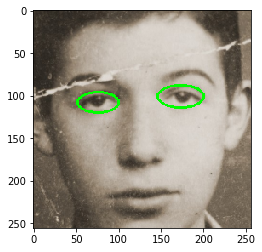

In [6]:
print('Identificando os olhos...', end = ' ')
true_eyes = roi.detect_eyes(face)
print('OK')

# Exibe os olhos identificados no rosto
face_copy = np.copy(face)
for (ex, ey, ew, eh) in true_eyes:
    cv2.ellipse(face_copy,(int(ex+0.5*ew), int(ey+0.5*eh)),(int(ew/2),int(eh/4)),0,0,360,(0, 255, 0),2)
plt.figure()
plt.imshow(face_copy)

Criando a máscara para o rosto... OK


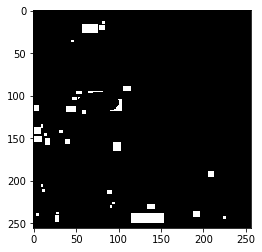

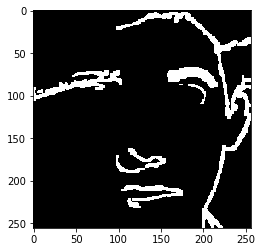

In [7]:
print('Criando a máscara para o rosto...', end = ' ')

face_rect_mask = mask.get_rect_mask(face)

face_mask = mask.get_mask(face)
mask.remove_eyes_from_mask(face_mask, true_eyes)

mixed = ~face_rect_mask & face_mask

face_mask_total = face_mask | face_rect_mask

mask.remove_eyes_from_mask(face_rect_mask, true_eyes)
mask.remove_border_from_mask(face_rect_mask)

print('OK')

# Salva a máscara do rosto em disco
cv2.imwrite(interm_dir + img_name + '_face_rect_mask' + img_extension, face_rect_mask)

# Exibe a maścara retangularizada
plt.figure()
plt.imshow(face_rect_mask, cmap='gray')

# Salva a máscara do rosto em disco
cv2.imwrite(interm_dir + img_name + '_face_mixed_mask' + img_extension, mixed)

# Exibe a maścara mixed
plt.figure()
plt.imshow(mixed, cmap='gray')

In [8]:
print('Verificando a porcentagem de dano no rosto...', end = ' ')
sem_dano = sum(sum(face_rect_mask == 0))
porcentagem_dano = 1-sem_dano/utils.FACE_SIZE**2
print(str(round(porcentagem_dano, 2)*100) + '% de dano no rosto.')

Verificando a porcentagem de dano no rosto... 3.0% de dano no rosto.


Restaurando o rosto com Generative Inpaint with Contextual Attention... OK


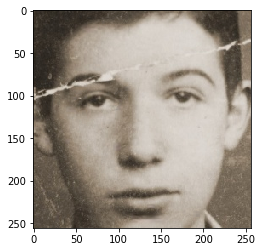

In [9]:
print('Restaurando o rosto com Generative Inpaint with Contextual Attention...', end = ' ')
face_inpaint = test.run_inpaint(image = interm_dir + img_name + '_cropped_redim' + img_extension,
                                 mask = interm_dir + img_name + '_face_rect_mask' + img_extension,
                                 output = interm_dir + img_name + '_face_rect_generative' + img_extension,
                                 checkpoint_dir = checkpoint_dir)
print('OK')

# Salvando a restauração obtida em disco
cv2.imwrite(interm_dir + img_name + '_face_rect_generative' + img_extension, cv2.cvtColor(face_inpaint, cv2.COLOR_BGR2RGB))

# Exibe a restauração obtida
plt.figure()
plt.imshow(face_inpaint)

In [ ]:
print('Restaurando o rosto com OpenCV...', end = ' ')
face_inpaint2 = cv2.inpaint(face, mixed, 3, cv2.INPAINT_TELEA)
print('OK')

# Salvando a restauração obtida em disco
cv2.imwrite(interm_dir + img_name + '_face_mixed_opencv' + img_extension, cv2.cvtColor(face_inpaint2, cv2.COLOR_BGR2RGB))

# Exibe a restauração obtida
plt.figure()
plt.imshow(face_inpaint2)

Restaurando o rosto com OpenCV... OK


In [ ]:
print('Combiando as restaurações do rosto...', end = ' ')

face_inpaint[mixed==255] = face_inpaint2[mixed==255]

print('OK')

# Salvando a restauração obtida em disco
cv2.imwrite(interm_dir + img_name + '_face_inpainting' + img_extension, cv2.cvtColor(face_inpaint, cv2.COLOR_BGR2RGB))

# Exibe a restauração obtida
plt.figure()
plt.imshow(face_inpaint)

# Redimensiona o rosto restaurado para o tamanho original
face_inpaint_redim = cv2.resize(face_inpaint, (w, h))
face_mask_total = cv2.resize(face_mask_total, (w, h))

In [ ]:
print('Criando a máscara do fundo da imagem...', end = ' ')

image_mask = mask.get_mask(image, "both")
mask.remove_face_from_mask(image_mask, x, y, w, h)

print('OK')

# Salva a máscara da imagem em disco
cv2.imwrite(interm_dir + img_name + '_image_mask' + img_extension, image_mask)

# Exibe a maścara do fundo da imagem
plt.figure()
plt.imshow(image_mask, cmap='gray')

In [ ]:
%%time
print('Restaurando o fundo da imagem...', end = ' ')

image_inpaint = cv2.inpaint(image, image_mask, 3, cv2.INPAINT_NS)

print('OK')

# Salva a restauração do fundo da imagem em disco
cv2.imwrite(interm_dir + img_name + '_image_inpainting' + img_extension, cv2.cvtColor(image_inpaint, cv2.COLOR_BGR2RGB))

# Exibe a imagem com o fundo restaurado
plt.figure()
plt.imshow(image_inpaint)

In [ ]:
print('Reconstruindo a imagem completa...', end = ' ')
image_final = np.copy(image_inpaint)
image_final[y:y+h, x:x+w][face_mask_total == 255] = face_inpaint_redim[face_mask_total == 255]
print('OK')

# Salva a restauração da imagem em disco
cv2.imwrite(inpaint_dir + img_name + '_inpainting' + img_extension, cv2.cvtColor(image_final, cv2.COLOR_BGR2RGB))

# Exibe a imagem restaurada
plt.figure()
plt.imshow(image_final)